In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database


import jetson_configs as jcfg
from src.ml_helpers.make_ml_dataset import *
from src.ml_helpers.make_baseline_models import *
from src.ml_helpers.fit_baseline_models import *
from src.ml_helpers.evaluate_models import *

# Get predictions

In [2]:
split_date     = jcfg.train_test_split
current_month  = jcfg.current_month
admin_level    = jcfg.admin_level
horizon        = jcfg.horizon

fpath       = f'{admin_level}_lag{horizon}'

# Configure connection

In [3]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [4]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

## Build the learning dataset

In [5]:
learn_df = make_ml_features(current_month, horizon, admin_level, sql_engine=engine)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_incidents', 'miss_malaria_cases', 'miss_measles_cases', 'miss_vegetation_cover_ndvi']


## Fit the models

In [6]:
predictions = pd.DataFrame(columns = ['a', 'b'],
                         index = pd.MultiIndex(levels =[[],[]], 
                                               codes =[[],[]], 
                                               names=['model_parameters', 'region']))

In [7]:
predictions = fit_baseline_models(learn_df, admin_level, horizon)

C:\Users\katherine\Dropbox\Personal\Personal\Academic\UNGP\Jetson\jetson_v1.1\experiment_2\src\ml_helpers\make_baseline_models.py:22: FutureWarning: The `center` argument on `expanding` will be removed in the future
  pred = naiive.expanding(center=False, min_periods=1).mean()


## Score the models

In [8]:
months = sorted(learn_df.index.get_level_values('date').unique().tolist())
n = months.index(pd.to_datetime(split_date)) + 1
train_dates, test_dates = months[:n], months[n:]

In [9]:
results = evaluate_predictions(predictions, train_dates, test_dates,
                              admin_level, horizon)

# Visualize the results

## Inspect the predictions for one region

Text(0.5, 1.0, 'Predictions for {region}')

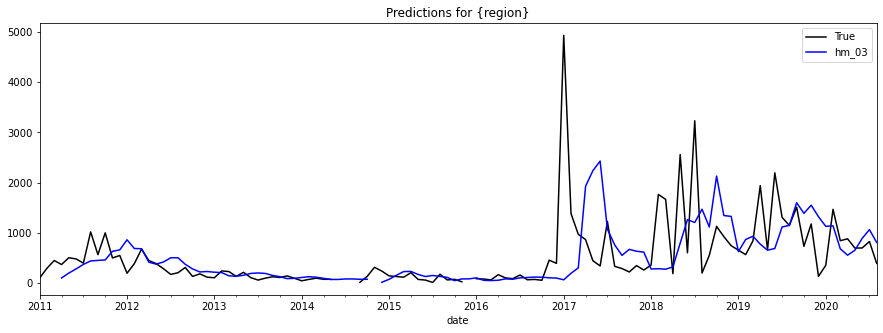

In [10]:
region     = 'Awdal'
model      = 'hm_03'
parameters = ''
plot_df    = predictions.xs("Awdal", level='region')[['true', model]]

ax = plot_df['true'].plot(color='black', figsize=[15,5], label='True', legend=True)
plot_df[model].plot(color='blue', ax=ax, label=model, legend=True)
ax.set_title("Predictions for {region}")

## View performance by train/test set

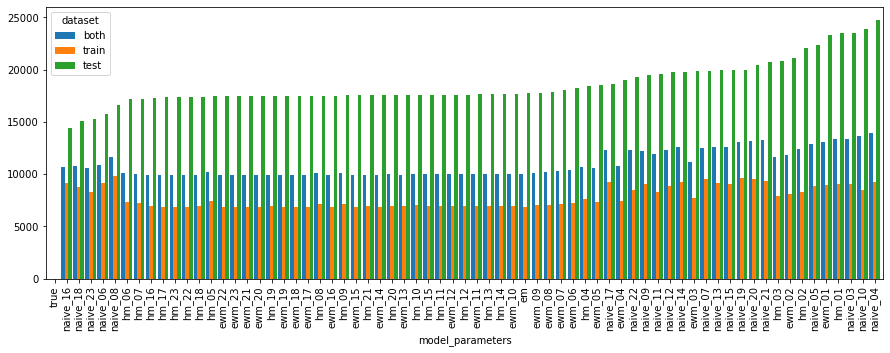

In [11]:
plot_df = results['all'].unstack(level='dataset').sort_values('test').xs("rmse", level="metric")
plot_df.plot(kind='bar', figsize=[15,5], width=.9)

In [12]:
results['all'].unstack(level='dataset').sort_values('test').xs("rmse", level="metric").loc['hm_12']

dataset
both     10031.294499
train     6968.752013
test     17622.291141
Name: hm_12, dtype: float64

## View actual error rates in best scenario

In [13]:
results['all'].unstack(level='dataset').xs("rmse", level="metric").sort_values('test', ascending=True).astype(int).head()

dataset,both,train,test
model_parameters,,,
true,0,0,0
naive_16,10667,9127,14430
naive_18,10759,8821,15100
naive_23,10614,8331,15253
naive_06,10914,9185,15734


In [14]:
predictions['true'].mean()

3036.294577976523

In [15]:
predictions['true'].std()

10151.053366444794

## View ranked results

In [16]:
results_for_ranking = results['all'].unstack(level='dataset').unstack(level=['metric'])["train"]

In [17]:
print("Best models - MAE  -----------------",  results_for_ranking['mae' ].sort_values().head(6).astype(int))
print("Best models - RMSE -----------------",  results_for_ranking['rmse'].sort_values().head(6).astype(int))
print("Best models - MAPE -----------------",  results_for_ranking['mape'].sort_values().head(6).round(2))

Best models - MAE  ----------------- model_parameters
true         0
em        2448
ewm_23    2499
ewm_22    2504
ewm_21    2509
ewm_20    2515
Name: mae, dtype: int32
Best models - RMSE ----------------- model_parameters
true         0
ewm_23    6821
ewm_22    6825
ewm_21    6830
ewm_20    6836
ewm_19    6842
Name: rmse, dtype: int32
Best models - MAPE ----------------- model_parameters
true        0.00
naive_05    4.75
naive_18    4.91
naive_11    5.06
naive_03    5.35
hm_01       5.35
Name: mape, dtype: float64


## Explore performance of naive predictions over time

### EWM

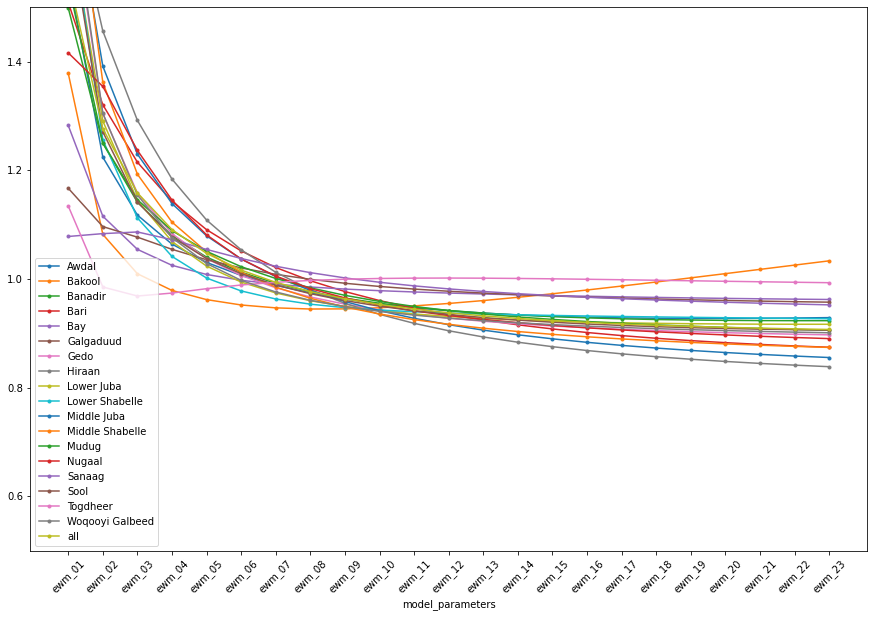

In [18]:
naive_predictions = [i for i in results_for_ranking.index.tolist() if 'ewm_' in i]

plot_df = results.loc[naive_predictions, 'mse', 'train']

plot_df = (plot_df/plot_df.mean()).reset_index(level=['metric', 'dataset'], drop=True)

ax = plot_df.plot(marker=".", figsize=[15,10], ylim=[0.5,1.5], rot=45)

ax.set_xticks(range(len(plot_df.index.get_level_values(0))))
ax.set_xticklabels(plot_df.index.get_level_values(0))
plt.show()

### HM

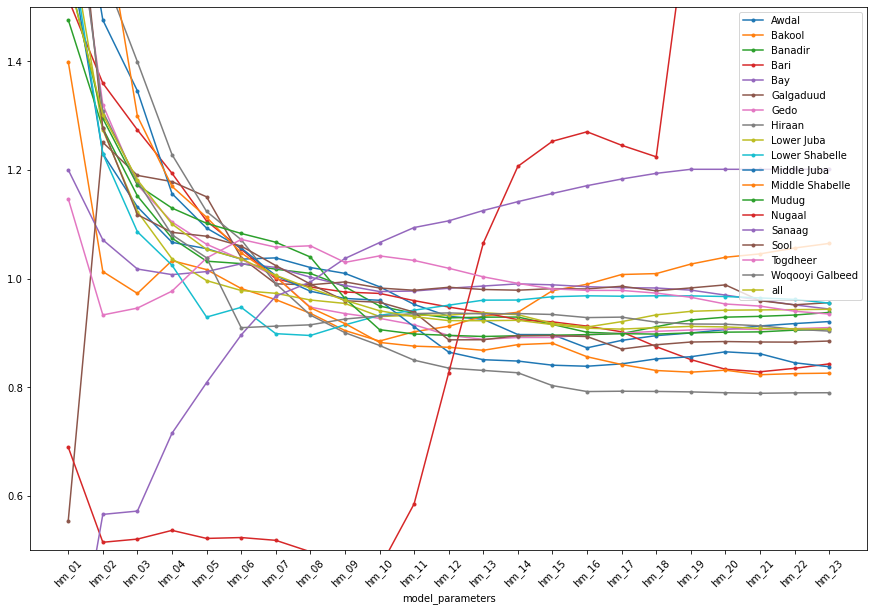

In [19]:
naive_predictions = [i for i in results_for_ranking.index.tolist() if 'hm_' in i]

plot_df = results.loc[naive_predictions, 'mse', 'train']

plot_df = (plot_df/plot_df.mean()).reset_index(level=['metric', 'dataset'], drop=True)

ax = plot_df.plot(marker=".", figsize=[15,10], ylim=[0.5,1.5], rot=45)

ax.set_xticks(range(len(plot_df.index.get_level_values(0))))
ax.set_xticklabels(plot_df.index.get_level_values(0))
plt.show()

## View error metrics by region and model

### Raw error metrics

#### MSE

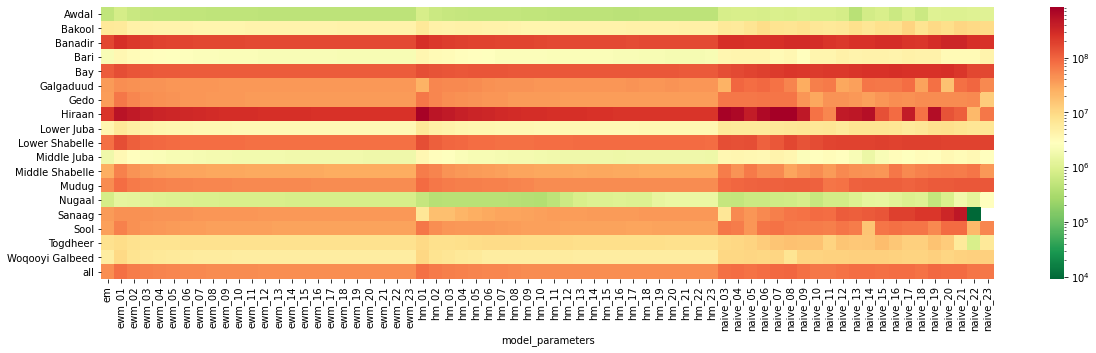

In [20]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mse', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

plt.savefig("figures/naive_raw_mse.png", dpi=100, bbox_inches="tight")

#### MAE

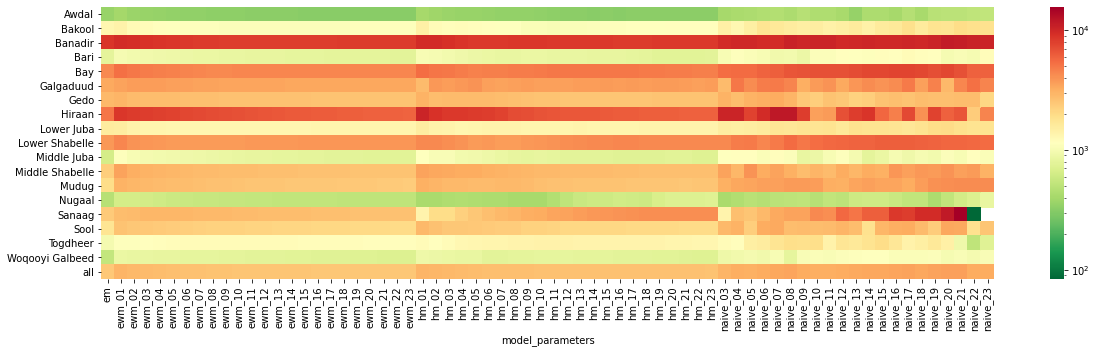

In [21]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mae', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

#### MAPE

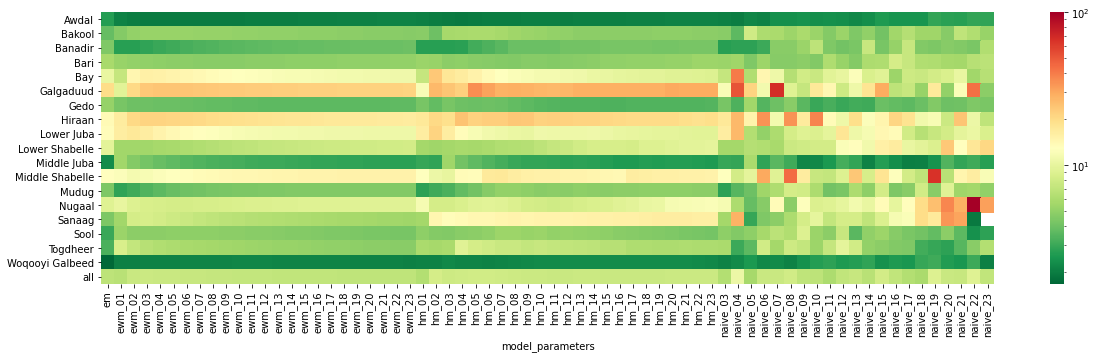

In [22]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mape', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

In [23]:
min_flow

1.6622624948176707

In [24]:
max_flow

100.6201661389735

### Ranked error metrics

#### MSE

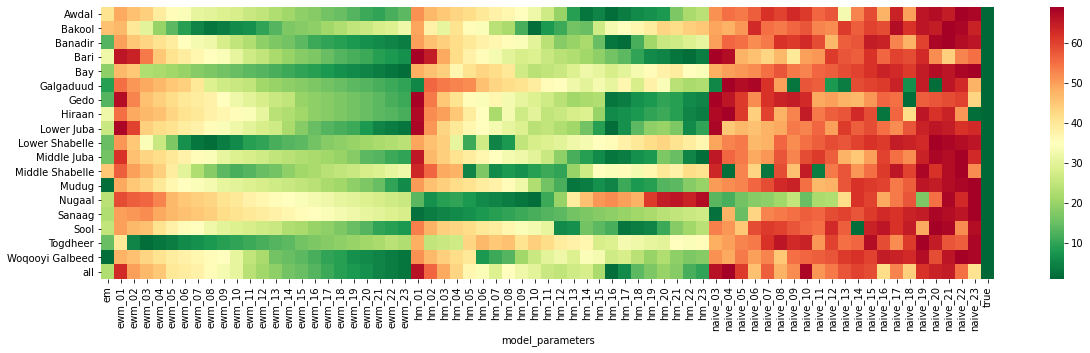

In [25]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df =  results.xs(['mse', 'both'], level=['metric', 'dataset']).astype(float).rank(axis=0) #.sort_values('all')
sns.heatmap(plot_df.T, ax=ax, cmap='RdYlGn_r')
plt.savefig("figures/naive_ranked_mse.png", dpi=100, bbox_inches="tight")

#### RMSE

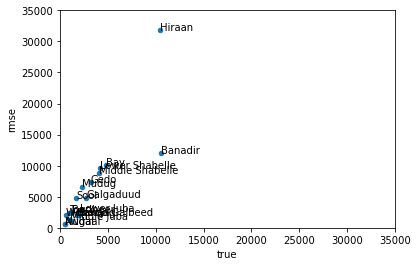

In [26]:
plot_df = pd.concat([
    results[results.index.get_level_values(0)!='true'].xs(['rmse', 'both'], level=['metric', 'dataset']).min(),
    predictions.unstack(level='region')['true'].mean()
    ], axis=1, sort=True)

plot_df.columns=['rmse', 'true']


ax = plot_df.plot(kind='scatter', x='true', y='rmse', xlim=[0,35000], ylim=[0,35000])

for i, row in plot_df.iterrows():
    ax.annotate(i, (row.true, row.rmse))

### Distribution of error metrics

#### By model

In [27]:
models1 = list(set( [i for i in results.index.get_level_values("model_parameters") if "ewm" in i]))
plot_df1 = results.loc[models1].xs("mse", level="metric").xs("train", level="dataset").stack()

In [28]:
models2 = list(set( [i for i in results.index.get_level_values("model_parameters") if "hm" in i]))
plot_df2 = results.loc[models2].xs("mse", level="metric").xs("train", level="dataset").stack()

In [29]:
models3 = list(set( [i for i in results.index.get_level_values("model_parameters") if "naive" in i]))
plot_df3 = results.loc[models3].xs("mse", level="metric").xs("train", level="dataset").stack()

No handles with labels found to put in legend.


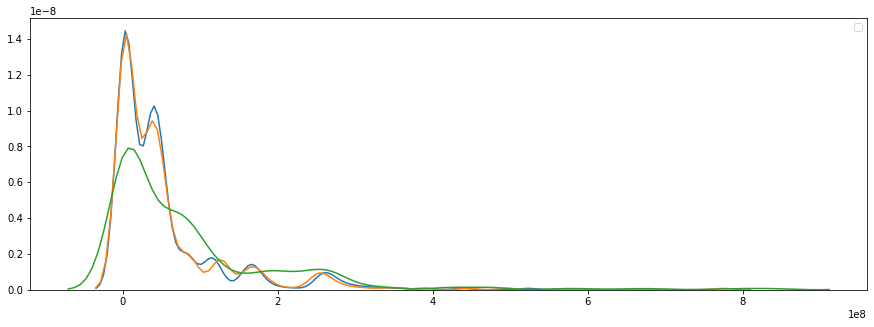

In [30]:
fig,ax=plt.subplots(1,1, figsize=[15,5])

sns.kdeplot(plot_df1, ax=ax)
sns.kdeplot(plot_df2, ax=ax)
sns.kdeplot(plot_df3, ax=ax)

ax.legend()

#### By region, for EWM model

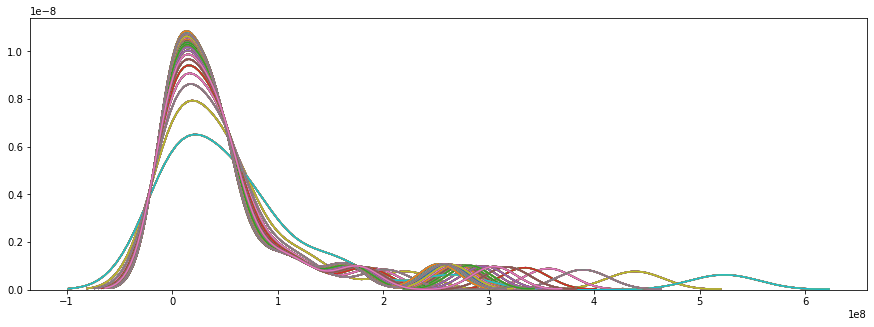

In [31]:
fig,ax=plt.subplots(1,1, figsize=[15,5])

for ewm in plot_df1.index.get_level_values(0):
    sns.kdeplot(plot_df1.loc[ewm], ax=ax, legend=False)

In [32]:
results.index.get_level_values('model_parameters').unique()

Index(['em', 'ewm_01', 'ewm_02', 'ewm_03', 'ewm_04', 'ewm_05', 'ewm_06',
       'ewm_07', 'ewm_08', 'ewm_09', 'ewm_10', 'ewm_11', 'ewm_12', 'ewm_13',
       'ewm_14', 'ewm_15', 'ewm_16', 'ewm_17', 'ewm_18', 'ewm_19', 'ewm_20',
       'ewm_21', 'ewm_22', 'ewm_23', 'hm_01', 'hm_02', 'hm_03', 'hm_04',
       'hm_05', 'hm_06', 'hm_07', 'hm_08', 'hm_09', 'hm_10', 'hm_11', 'hm_12',
       'hm_13', 'hm_14', 'hm_15', 'hm_16', 'hm_17', 'hm_18', 'hm_19', 'hm_20',
       'hm_21', 'hm_22', 'hm_23', 'naive_03', 'naive_04', 'naive_05',
       'naive_06', 'naive_07', 'naive_08', 'naive_09', 'naive_10', 'naive_11',
       'naive_12', 'naive_13', 'naive_14', 'naive_15', 'naive_16', 'naive_17',
       'naive_18', 'naive_19', 'naive_20', 'naive_21', 'naive_22', 'naive_23',
       'true'],
      dtype='object', name='model_parameters')

In [33]:
results.loc['naive_03', 'all']

metric  dataset
mse     both       1.789466e+08
        train      8.186043e+07
        test       5.524669e+08
rmse    both       1.337709e+04
        train      9.047675e+03
        test       2.350461e+04
mae     both       3.636319e+03
        train      3.037149e+03
        test       5.941512e+03
mape    both       6.766801e+00
        train      5.349121e+00
        test       1.222105e+01
Name: all, dtype: float64